In [1]:
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
import torch.utils.checkpoint as checkpoint
import torch.utils.data

import matplotlib.pyplot as plt

from torchvision.io import read_image

import os
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset

import torchvision.transforms.functional

from PIL import Image

from sklearn import preprocessing

from model import UNet

In [2]:
"""
Creating a dataset
"""    

# Dataset hyperparameters

output_size = (256, 256) # Decrease the image size to increase the speed (Maybe wont work)


class SpineDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.classes = os.listdir(data_dir)

        self.all_files = []
        for root, dirs, files in os.walk(data_dir):
            for filename in files:
                class_name = os.path.basename(root)
                file_tuple = (class_name, os.path.join(root, filename))
                self.all_files.append(file_tuple)
    
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, index):
        img = Image.open(self.all_files[index][1])
        resized_img = img.resize(output_size)
        img_np = np.array(resized_img)

        # L2 normalization - Unit norm
        img_np = preprocessing.normalize(img_np)

        # Min-max normalization: Values from 0 to 1
        img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np))

        output_image = torch.from_numpy(img_np).float()
        
        return self.classes.index(self.all_files[index][0]), output_image


def plot_image (np_arr):
    plt.imshow(np_arr, cmap='gray')
    plt.show()


28


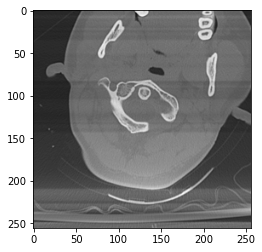

tensor(0.) tensor(1.)


In [3]:
# Testing a single image from the dataset and checking preprocessing 
path = "C:\\Users\\alist\\WorkCodes\\Datasets\\RSNA Cervical Spine CSFD\\CSFD Ver1"

idx = 10000
dataset = SpineDataset(path)
print(dataset[idx][0])
plot_image(dataset[idx][1])
print (dataset[idx][1].min(), dataset[idx][1].max())

# plot_image(preprocessing.normalize(dataset[idx][1]))
# print (dataset[idx][1].min(), dataset[idx][1].max(), preprocessing.normalize(dataset[idx][1]).min(), preprocessing.normalize(dataset[idx][1]).max())

In [4]:
# Define split sizes
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the whole dataset into train and test dataset. Is validation needed?
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import gc

def clean_memory():
    #Clean all memory unused
    print(torch.cuda.memory_summary())

    torch.cuda.empty_cache()
    gc.collect() #force garbage collection
    print(f"Current GPU memory usage: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

#clean_memory()

In [6]:
# Testing if model works correctly
sample_inp = torch.randn([1,1,256,256])
test_model = UNet(1, 63)

test_model(sample_inp).max()

tensor(0.6746, grad_fn=<MaxBackward1>)

In [7]:
model = UNet(1, 63).to(device)

In [8]:
from torch.nn.utils import clip_grad_norm_
# Define hyperparameters
learning_rate = 0.001
num_epochs = 2

# Define dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size = 50)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# Load checkpoint ==============================
checkpoint = torch.load('checkpoint-UNet-Spine-Cord-0.pth')

# Extract relevant data from checkpoint
#epoch = checkpoint['epoch']
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#loss = checkpoint['loss']
# ==============================================



<All keys matched successfully>

In [9]:
# Train model

model.train()
running_loss = 0

for epoch in range(num_epochs):
    for counter, (labels, images) in enumerate(train_loader):
        images = images.unsqueeze(dim = 1).cuda()
        #print (images.shape)

        outputs = model(images)
        
        #log_probs = torch.log(outputs)
        #loss = criterion(log_probs, labels.cuda())

        loss = criterion (outputs, labels.cuda())

        optimizer.zero_grad()
        loss.backward()

        clip_grad_norm_(model.parameters(), max_norm=1) # clip gradients
        optimizer.step()

        running_loss += loss.item()
        #print (outputs.argmax(dim = 1), labels)
        """combined_tensor = torch.stack([outputs.argmax(dim = 1).cpu(), labels], dim=1)
        print(combined_tensor)"""

        if counter % 20 == 19:
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item(),
            },  'checkpoint-UNet-Spine-Cord-' + str(epoch) + '.pth')
            print( "epoch:", epoch, "iteration:", counter, "Average cost function", running_loss/20)
            running_loss = 0

epoch: 0 iteration: 19 Average cost function 0.21540682725608348
epoch: 0 iteration: 39 Average cost function 0.1941853106021881
epoch: 0 iteration: 59 Average cost function 0.19891720563173293
epoch: 0 iteration: 79 Average cost function 0.20614561066031456
epoch: 0 iteration: 99 Average cost function 0.17261619716882706
epoch: 0 iteration: 119 Average cost function 0.19323790036141872
epoch: 0 iteration: 139 Average cost function 0.16914225071668626
epoch: 0 iteration: 159 Average cost function 0.1892474763095379
epoch: 0 iteration: 179 Average cost function 0.22576003782451154
epoch: 0 iteration: 199 Average cost function 0.18096948526799678
epoch: 0 iteration: 219 Average cost function 0.1771153561770916
epoch: 0 iteration: 239 Average cost function 0.20048925578594207
epoch: 0 iteration: 259 Average cost function 0.19822164960205554
epoch: 0 iteration: 279 Average cost function 0.1884721230715513
epoch: 0 iteration: 299 Average cost function 0.17350360341370105
epoch: 0 iteration:

In [10]:
import random
random_integers = [random.randint(0, 4000) for _ in range(50)]

In [13]:
model.eval()
# print (dataset[0][1].shape)

lss = 0
totalloss = 0
data_eval = test_dataset
correct = 0

for idx in random_integers:
    temp_inp = data_eval[idx][1].cuda().unsqueeze(dim = 0).unsqueeze(dim = 0)
    out = model(temp_inp)
    
    lbl = data_eval[idx][0]

    lss = criterion(out, torch.tensor([lbl]).cuda())
    totalloss += lss
    print (out.argmax(dim = 1).item(), lbl , lss.item())
    if out.argmax(dim = 1).item() == lbl:
        correct += 1

print (totalloss.item()/len(random_integers))
print (correct/50)
    

52 52 0.032082244753837585
10 10 0.0340653620660305
54 54 0.0985744521021843
5 5 0.13663728535175323
50 50 0.06925271451473236
38 38 0.24892276525497437
60 60 0.03779694810509682
48 48 0.11085491627454758
60 23 1.419053316116333
29 29 0.2663590908050537
2 2 0.018704812973737717
9 9 0.0270296148955822
38 6 1.2407135963439941
54 54 0.0985744521021843
35 35 0.693943202495575
36 36 0.0010083595989271998
54 54 0.14639043807983398
3 3 0.17498593032360077
51 51 0.2124326080083847
36 36 0.0010083595989271998
26 26 0.004810545593500137
18 18 0.030566800385713577
30 30 0.0003197873884346336
22 22 0.004570513963699341
8 8 0.04491262137889862
18 18 0.2688767611980438
8 8 0.026062848046422005
15 15 0.00013648532330989838
21 21 0.0032467530108988285
56 56 0.1574690341949463
37 37 0.008491599932312965
22 22 0.10336074978113174
16 16 0.19527652859687805
23 23 0.5739128589630127
38 0 0.8497622013092041
38 38 0.28576982021331787
4 4 0.051579467952251434
29 29 0.19887472689151764
36 36 0.0091651203110814

In [14]:
print ("After test, the percentage of correctly guessed:", correct/50, "\t average loss:", totalloss.item()/len(random_integers))

After test, the percentage of correctly guessed: 0.92 	 average loss: 0.23818609237670899


In [62]:
#out = nn.Softmax(dim = 1)(out)
print (out[0].argmax().item(), test_output)
print (out.max())
print (test_output)
out[0][15]

54 0
tensor(0.9721, device='cuda:0', grad_fn=<MaxBackward1>)
0


tensor(1.1511e-23, device='cuda:0', grad_fn=<SelectBackward0>)

In [58]:
try_inp = torch.tensor([0.0, 0.0001, 0.5, 0]).unsqueeze(0)
log_probs = torch.log(try_inp) # apply log to softmax outputs
print(try_inp.shape)

try_out = torch.tensor([2])
print (try_out.shape)

criterion = nn.NLLLoss()
loss = criterion(log_probs, try_out)
print (loss.item())

torch.Size([1, 4])
torch.Size([1])
0.6931471824645996


In [27]:
batch_size = 1
num_classes = 63
output = torch.randn(batch_size, num_classes)
output = nn.Softmax(dim=1)(output)

print (output.shape)
print (labels.shape)
# create a sample label tensor with shape (batch_size,)
labels = torch.tensor([42])

# compute the Cross Entropy Loss
criterion = nn.CrossEntropyLoss()
loss = criterion(output, labels)

# print the loss value
print(loss.item())

torch.Size([1, 63])
torch.Size([1])
4.1366496086120605


0.7436684370040894


In [24]:
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output

tensor(1.7408, grad_fn=<NllLossBackward0>)